#  Прогнозирование заказов такси

В нашем распоряжении исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

RAND = 22

# Чтение данных

In [2]:
df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В нашей выборке 26496 наблюдений с интервалом в одну минуту. Проверим сохранен ли порядок

In [4]:
df.index.is_monotonic

True

Данные упорядочены. Выполним ресемплирование по одному часу

In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
df.isna().sum()

num_orders    0
dtype: int64

# Анализ данных

Для детального анализа данных добавим дополнительные столбцы

In [7]:
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour 
df.head(10)

,num_orders,month,day,dayofweek,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4
2018-03-01 05:00:00,6,3,1,3,5
2018-03-01 06:00:00,12,3,1,3,6
2018-03-01 07:00:00,15,3,1,3,7
2018-03-01 08:00:00,34,3,1,3,8


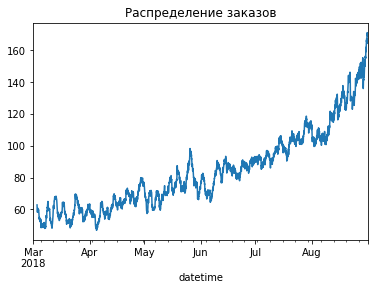

In [8]:
df['num_orders'].rolling(50).mean().plot()
plt.title('Распределение заказов')
plt.show()

В данных есть восходящий тренд. Этот подъём действительно за счёт роста компании или есть влияние сезонности? Скорее всего здесь влияние месячной сезонности, потому что летом люди начинают больше путешествовать и, соответственно, мы видим рост заказов такси

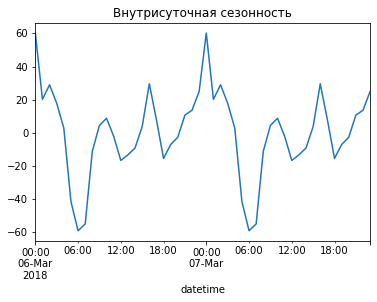

In [9]:
# раскладываем временной ряд на три составляющие: тренд, сезонность и остаток
decomposed = seasonal_decompose(df['num_orders'])
decomposed.seasonal['2018-03-06':'2018-03-07'].plot()
plt.title('Bнутрисуточная сезонность')
plt.show()

In [10]:
df.groupby('hour')['num_orders'].mean().sort_values(ascending=False).head(5)

hour
0     144.402174
16    114.146739
2     113.070652
23    109.766304
1     104.364130
Name: num_orders, dtype: float64

In [11]:
df.groupby('hour')['num_orders'].mean().sort_values().head(5)

hour
6     25.173913
7     29.271739
5     42.630435
12    67.630435
18    69.358696
Name: num_orders, dtype: float64

В 12 часов ночи - пик заказов такси. Видимо, ночью не работает общественный транспорт, поэтому люди вынуждены ехать на такси.  
А утром меньше всего заказов.

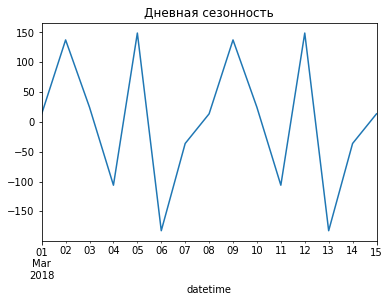

In [12]:
decomposed = seasonal_decompose(df.resample('1D').sum()['num_orders'])
decomposed.seasonal['2018-03-01':'2018-03-15'].plot()
plt.title('Дневная сезонность')
plt.show()

In [13]:
df.resample('1D').median()['dayofweek'].map({
    1.0: 'Понедельник',
    2.0: 'Вторник',
    3.0: 'Среда',
    4.0: 'Четверг',
    5.0: 'Пятница',
    6.0: 'Суббота',
    0.0: 'Воскресенье',
})['2018-03-01':'2018-03-15']

datetime
2018-03-01          Среда
2018-03-02        Четверг
2018-03-03        Пятница
2018-03-04        Суббота
2018-03-05    Воскресенье
2018-03-06    Понедельник
2018-03-07        Вторник
2018-03-08          Среда
2018-03-09        Четверг
2018-03-10        Пятница
2018-03-11        Суббота
2018-03-12    Воскресенье
2018-03-13    Понедельник
2018-03-14        Вторник
2018-03-15          Среда
Freq: D, Name: dayofweek, dtype: object

Люди чаще всего заказывают такси в четверг и воскресенье. Меньше всего заказов - в понедельник и субботу.

# Обучение моделей

Заново загрузим данные

In [14]:
df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
df = df.resample('1H').sum()

In [15]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Добавим дополнительные признаки

In [16]:
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df.head()

,num_orders,dayofweek,hour
datetime,,,
2018-03-01 00:00:00,124,3,0
2018-03-01 01:00:00,85,3,1
2018-03-01 02:00:00,71,3,2
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,3,4


Создадим один признак сдвига в 1 час и признак скользящего среднего, который считается по 24 объектам, т.е. за 1 день

In [17]:
df['lag_1'] = df['num_orders'].shift(1)
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()
df.head()

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN


Подготовим данные для обучения

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [19]:
train.shape, test.shape

((3950, 5), (442, 5))

In [20]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [21]:
# функция для расчета rmse

def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

## Линейная регрессия

In [22]:
model = LinearRegression()

parameters = {
    'copy_X': [True, False],
    'fit_intercept':[True, False],
    'n_jobs': [-1, 1, 2, 3, 4, None]
}

tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model, parameters, scoring=rmse_score, n_jobs=-1, cv=tscv)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'copy_X': True, 'fit_intercept': False, 'n_jobs': -1}


In [23]:
model = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(rmse(y_test, pred))

51.108283569922236


## Случайный лес

In [24]:
model = RandomForestRegressor(random_state=RAND)

parameters = {
    'max_depth': [5, 8, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model, parameters, scoring=rmse_score, n_jobs=-1, cv=tscv, verbose=100)

In [25]:
# grid.fit(X_train, y_train)

In [26]:
# grid.best_params_

# {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10}

In [27]:
model = RandomForestRegressor(random_state=RAND)

parameters = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 12, 15],
    'min_samples_leaf': [2, 3, 4]
}

tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model, parameters, scoring=rmse_score, n_jobs=-1, cv=tscv, verbose=100)

In [28]:
# grid.fit(X_train, y_train)

In [29]:
# grid.best_params_

# {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 12}

In [30]:
model = RandomForestRegressor(min_samples_leaf=2, random_state=RAND)

parameters = {
    'max_depth': [18, 20, 22],
    'min_samples_split': [11, 12, 13]
}

tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model, parameters, scoring=rmse_score, n_jobs=-1, cv=tscv, verbose=100)

In [31]:
# grid.fit(X_train, y_train)

In [32]:
# grid.best_params_

# {'max_depth': 18, 'min_samples_split': 12}

In [33]:
model = RandomForestRegressor(min_samples_leaf=2, min_samples_split=12, random_state=RAND)

parameters = {
    'max_depth': [16, 17, 18, 19]
}

tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model, parameters, scoring=rmse_score, n_jobs=-1, cv=tscv, verbose=100)

In [34]:
# grid.fit(X_train, y_train)

In [35]:
# grid.best_params_

# {'max_depth': 18}

In [36]:
model = RandomForestRegressor(max_depth=18, min_samples_leaf=2, min_samples_split=12, random_state=RAND)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(rmse(y_test, pred))

46.021522681035805


## LightGBM

In [37]:
parameters = {
    'max_depth': [5, 7, 10],
    'num_leaves': [50, 80, 110],
    'n_estimators': [100, 300, 500]
}

model = LGBMRegressor(random_state=RAND)
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model, parameters, scoring=rmse_score, n_jobs=-1, cv=tscv, verbose=100)

In [38]:
# grid.fit(X_train, y_train)

In [39]:
# grid.best_params_

# {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 50}

In [40]:
parameters = {
    'max_depth': [4, 5, 6],
    'num_leaves': [40, 50, 60],
    'n_estimators': [50, 100, 150]
}

model = LGBMRegressor(random_state=RAND)
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model, parameters, scoring=rmse_score, n_jobs=-1, cv=tscv, verbose=100)

In [41]:
# grid.fit(X_train, y_train)

In [42]:
# grid.best_params_

# {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 40}

In [43]:
parameters = {
    'num_leaves': [35, 40, 45],
    'n_estimators': [80, 100, 120]
}

model = LGBMRegressor(max_depth=5, random_state=RAND)
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model, parameters, scoring=rmse_score, n_jobs=-1, cv=tscv, verbose=100)

In [44]:
# grid.fit(X_train, y_train)

In [45]:
# grid.best_params_

# {'n_estimators': 100, 'num_leaves': 35}

In [46]:
parameters = {
    'num_leaves': [25, 30, 35],
    'n_estimators': [95, 100, 105]
}

model = LGBMRegressor(max_depth=5, random_state=RAND)
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model, parameters, scoring=rmse_score, n_jobs=-1, cv=tscv, verbose=100)

In [47]:
# grid.fit(X_train, y_train)

In [48]:
# grid.best_params_

# {'n_estimators': 100, 'num_leaves': 30}

In [49]:
parameters = {
    'num_leaves': [26, 28, 30, 32, 34],
    'n_estimators': [96, 98, 100, 102, 104]
}

model = LGBMRegressor(max_depth=5, random_state=RAND)
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model, parameters, scoring=rmse_score, n_jobs=-1, cv=tscv, verbose=100)

In [50]:
# grid.fit(X_train, y_train)

In [51]:
# grid.best_params_

# {'n_estimators': 102, 'num_leaves': 28}

In [52]:
model = LGBMRegressor(max_depth=5, n_estimators=102, num_leaves=28, random_state=RAND)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(rmse(y_test, pred))

43.18571542750772


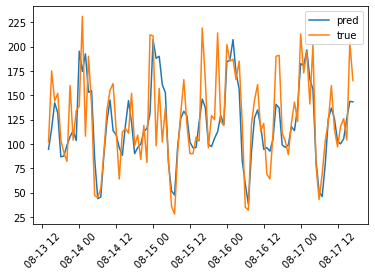

In [53]:
y_pred = pd.Series(model.predict(X_test[:100]), index=y_test[:100].index)
y_true = y_test[:100]
plt.plot(y_pred, label='pred')
plt.plot(y_true, label='true')
plt.legend()
plt.xticks(rotation=45)
plt.show()

В интервале пяти дней, предсказанные значения почти совпадают с истинными. Только у истинных значений присутствуют более выразительные колебания

# Вывод

В этом проекте мы работали с временными рядами, историческими данными о заказах такси в аэропортах. Сначала мы проанализировали данные и пришли к таким выводам:  
  
1. В течение данного интервала времени (март-сентябрь 2018 года) виден растущий тренд количества заказов такси, но возможно он обусловлен месячной сезонностью. Продажи летом увеличиваются, и именно это мы наблюдаем в наших данных.
2. Больше всего заказов приходится в четверг и воскресенье, меньше всего - в субботу и понедельник;  
3. В 12 часов ночи - пик заказов такси. Утром меньше всего заказов
  
Затем мы обучали различные модели, чтобы спрогнозировать количество заказов такси на следующий час. Лучшим оказался градиентный бустинг библиотеки LightGBM. Показатель RMSE на тестовой выборке составил 43